# Regressor
1. load datasets
1. sample from datasets
1. construct features
1. construct labels (load from logs)

In [1]:
# load datasets:


import importlib
import random
import argparse
import configparser
import numpy as np
import networkx as nx
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_sparse
from torch import Tensor
from torch.nn import Linear
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

from torch_geometric.utils import negative_sampling, to_networkx
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator


import networkx as nx
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import scipy
import math


from dataset_utils import node_feature_utils
from dataset_utils.node_feature_utils import *
import my_utils as utils
import sys,os
sys.path.append(os.getcwd())


importlib.reload(utils)

Using backend: pytorch


<module 'my_utils' from '/li_zhengdao/github/GenerativeGNN/my_utils.py'>

In [2]:
# Load specific dataset:




from PrepareDatasets import DATASETS
import my_utils
import dataset_utils


print(DATASETS.keys())
"""
    'REDDIT-BINARY': RedditBinary,
    'REDDIT-MULTI-5K': Reddit5K,
    'COLLAB': Collab,
    'IMDB-BINARY': IMDBBinary,
    'IMDB-MULTI': IMDBMulti,
    'ENZYMES': Enzymes,
    'PROTEINS': Proteins,
    'NCI1': NCI1,
    'DD': DD,
    "MUTAG": Mutag,
    'CSL': CSL
"""

data_names = ['PROTEINS']
data_names = ['DD']
data_names = ['ENZYMES']
data_names = ['NCI1']
data_names = ['IMDB-MULTI']
data_names = ['REDDIT-BINARY']
data_names = ['CIFAR10']
data_names = ['ogbg_molhiv']


# NOTE:new kernel:
data_names = ['DD', 'PROTEINS', 'ENZYMES']

data_names = ['ogbg_moltox21','ogbg-molbace']

data_names = ['MUTAG']
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat
    # print(type(dat.dataset.get_data()))

dict_keys(['REDDIT-BINARY', 'REDDIT-MULTI-5K', 'COLLAB', 'IMDB-BINARY', 'IMDB-MULTI', 'NCI1', 'AIDS', 'ENZYMES', 'PROTEINS', 'DD', 'MUTAG', 'CSL', 'CIFAR10', 'MNIST', 'PPI', 'hiv', 'bace', 'bbpb', 'ogbg_molhiv', 'ogbg_ppa', 'PTC', 'QM9', 'ogbg_moltox21', 'ogbg-molbbbp', 'ogbg-molbace', 'syn_cc'])
loaded dataset, name: MUTAG
processed_dir:  DATA/MUTAG/processed
load dataset !
!!!! _dim_target:  2
dataset len:  188
load splits: DATA/MUTAG/processed/MUTAG_splits.json
split counts: 10


In [10]:
# extract features: mean, std of: avg, pooling, cc, tri_num, cycle4_num, ..., kernel features

import dataset_utils.node_feature_utils as nfu
from scipy.stats import pearsonr



def extract_features(adjs, labels):
    
    def get_mean_std_corr(features, labels):
        
        mean = np.array(np.mean(features))
        std = np.array(np.std(features))
        x = np.array(features).reshape(-1)
        y = np.array(labels)
        corr , _ = pearsonr(x, y)
        
        if np.isnan(corr):
            corr = np.array([0])
        
        if not isinstance(corr, np.ndarray):
            corr = np.array([corr])
            
        return np.array([mean.item(), std.item(), corr.item()])

    
    # F1: avgD:
    avg_d = [nfu.graph_avg_degree(adj=adj) for adj in adjs]
    f_avgD = get_mean_std_corr(avg_d, labels)
    # F2: avgCC:
    avg_cc = [nfu.node_cc_avg_feature(adj=adj) for adj in adjs]
    f_avgCC = get_mean_std_corr(avg_cc, labels)
    
    # F3: avgD/N:
    avg_DN = [nfu.graph_avgDN_feature(adj=adj) for adj in adjs]
    f_avgDN = get_mean_std_corr(avg_DN, labels)
    
    # F4: node num N:
    avg_N = [adj.shape[0] for adj in adjs]
    f_avgN = get_mean_std_corr(avg_N, labels)
    
    # F5: labels
    f_Y = get_mean_std_corr(labels, labels)[:2]
    
    # F6: cycles:
    avg_cyc = [nfu.graph_cycle_feature(adj=adj,k='4-5-6-7') for adj in adjs]
    f_cyc4 = get_mean_std_corr([c[0] for c in avg_cyc], labels)
    f_cyc5 = get_mean_std_corr([c[1] for c in avg_cyc], labels)
    f_cyc6 = get_mean_std_corr([c[2] for c in avg_cyc], labels)
    f_cyc7 = get_mean_std_corr([c[3] for c in avg_cyc], labels)
    
        
    feas = np.concatenate([f_avgD, f_avgCC, f_avgDN, f_avgN, f_Y, f_cyc4, f_cyc5, f_cyc6, f_cyc7], axis=0)
    return feas
    
    

In [11]:
dataset = datasets_obj['MUTAG']
adjs = dataset.get_dense_adjs(dataset.dataset)
labels = [d.y for d in dataset.dataset]

feas = extract_features(adjs=adjs, labels=labels)

In [34]:
# TODO: load each fold logs to construct y:
import json

# MUTAG:
# GIN_degree_log_path: [result_GIN_0403_GIN_degree_MUTAG]
# MLP_log_path: [result_GIN_0403_GIN_degree_MUTAG]
# GIN_degree_log_path: [result_GIN_0403_GIN_degree_MUTAG]
"""
{"best_config": {"config": {"model": "GIN", "device": "cuda:1", "batch_size": 64, "learning_rate": 0.0001, "classifier_epochs": 200, "hidden_units": [64, 64, 64, 64], "layer_num": 5, "optimizer": "Adam", "scheduler": {"class": "StepLR", "args": {"step_size": 50, "gamma": 0.5}}, "loss": "MulticlassClassificationLoss", "train_eps": false, "l2": 0.0, "aggregation": "sum", "gradient_clipping": null, "dropout": 0.5, "early_stopper": {"class": "Patience", "args": {"patience": 50, "use_loss": false}}, "shuffle": true, "resume": false, "additional_features": "degree", "node_attribute": false, "shuffle_feature": false, "roc_auc": false, "mol_split": false, "dataset": "syn_cc", "config_file": "gnn_comparison/config_GIN_lzd_degree.yml", "experiment": "endtoend", "result_folder": "results/result_0422_GIN_lzd_degree_syn_cc_0.1", "dataset_name": "syn_cc", "dataset_para": "0.1", "outer_folds": 10, "outer_processes": 2, "inner_folds": 5, "inner_processes": 1, "debug": true, "ogb_evl": false}, "TR_score": 16.183574925298277, "VL_score": 21.505376272304083, "TR_roc_auc": -1, "VL_roc_auc": -1}, "OUTER_TR": 14.774557204254199, "OUTER_TS": 11.003236511378612, "OUTER_TR_ROCAUC": -1, "OUTER_TE_ROCAUC": -1}
"""


_OUTER_RESULTS_FILENAME = 'outer_results.json'


def get_test_acc(data_root_path, fold=10):
    if data_root_path is None:
        return [None for _ in range(fold)]
    
    outer_TR_scores,outer_TS_scores,outer_TR_ROCAUC,outer_TE_ROCAUC = [],[],[],[]
    for i in range(1, fold+1):
        config_filename = os.path.join(data_root_path, f'OUTER_FOLD_{i}', _OUTER_RESULTS_FILENAME)

        with open(config_filename, 'r') as fp:
            outer_fold_scores = json.load(fp)

            outer_TR_scores.append(outer_fold_scores['OUTER_TR'])
            outer_TS_scores.append(outer_fold_scores['OUTER_TS'])
            
            if 'OUTER_TR_ROCAUC' in outer_fold_scores:
                outer_TR_ROCAUC.append(outer_fold_scores['OUTER_TR_ROCAUC'])
                outer_TE_ROCAUC.append(outer_fold_scores['OUTER_TE_ROCAUC'])

    return outer_TS_scores


# Load splits and logs for each fold

In [6]:
# syn_cc datasets:

syn_cc_GNN_test_acc = []

for i in range(1, 10):
    data_root_path = f'./results/result_0422_GIN_lzd_degree_syn_cc_{i/10}/GIN_syn_cc_assessment/10_NESTED_CV'
    syn_cc_GNN_test_acc.append(get_test_acc(data_root_path))
    

syn_cc_MLP_test_acc = []

for i in range(1, 10):
    data_root_path = f'./results/result_0422_Baseline_lzd_mlp_syn_cc_{i/10}/MolecularGraphMLP_syn_cc_assessment/10_NESTED_CV'
    syn_cc_MLP_test_acc.append(get_test_acc(data_root_path))  

In [7]:
# construct E of each fold, and plot

# Effectiveness 

def get_E(Acc_MLP_avg_degree, Acc_GNN_degree, Acc_MLP_attr, Acc_GNN_attr):
    factor = 0.5
    if Acc_MLP_avg_degree is None:
        E_struct = 0
        factor = 1
    else:
        E_struct = (abs(Acc_GNN_degree - Acc_MLP_avg_degree) / Acc_MLP_avg_degree) * (100 - min(Acc_GNN_degree, Acc_MLP_avg_degree))
    
    if Acc_MLP_attr is None:
        E_attribute = 0
        factor = 1
    else:
        E_attribute = (abs(Acc_GNN_attr - Acc_MLP_attr) / Acc_MLP_attr) * (100 - min(Acc_GNN_attr, Acc_MLP_attr))
    return (E_struct+E_attribute) * factor

# NOTE: get E for each dataset:

def plot_E(es, ax=None):
    e_res = sorted(es, key=lambda x:x[0])
    labels = [e[1] for e in e_res]

    if ax is None:
        fig, ax = plt.subplots(dpi=100)
        
    for e in e_res:
        bars = ax.bar(e[1], e[0], label=e[1], hatch='\\', edgecolor='black', linewidth=0.5)

    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='center')
    ax.set_axisbelow(True)
    ax.grid(linestyle='dashed',zorder=0)
    ax.set_title('E=(E_struct+E_attr)/2')

# ax.legend()

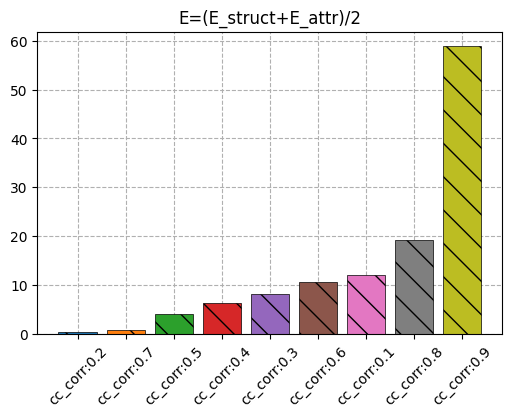

In [30]:
sy_es = []
for i in range(len(syn_cc_GNN_test_acc)):
    # cc_MLP_avg_degree, Acc_GNN_degree, Acc_MLP_attr, Acc_GNN_att
    sy_es.append((get_E(np.mean(syn_cc_MLP_test_acc[i]), np.mean(syn_cc_GNN_test_acc[i]),
                       None, None), f'cc_corr:{(i+1)/10}'))

plot_E(sy_es)

In [4]:
# Check mutag
# construct each E with each fold and

data_root_path = f'./results/result_GIN_0404_GIN_attr_MUTAG/GIN_MUTAG_assessment/10_NESTED_CV'
mutag_GNN_attr_test_acc=get_test_acc(data_root_path)


data_root_path = f'./results/result_GIN_0327_finger_mlp_attr_multicrossen_MUTAG/MolecularFingerprint_MUTAG_assessment/10_NESTED_CV'
mutag_MLP_attr_test_acc = get_test_acc(data_root_path)

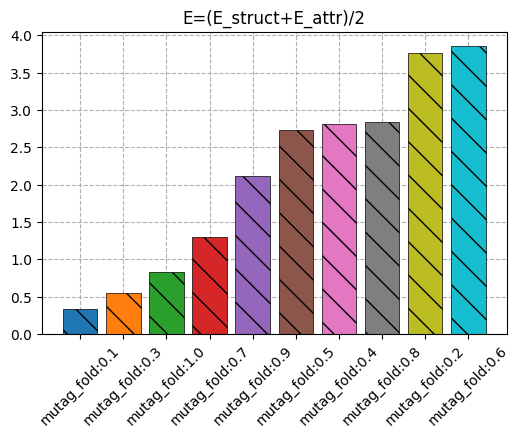

In [5]:
# Check mutag
# construct each E with each fold and

data_root_path = f'./results/result_GIN_0404_GIN_attr_MUTAG/GIN_MUTAG_assessment/10_NESTED_CV'
mutag_GNN_attr_test_acc=get_test_acc(data_root_path)


data_root_path = f'./results/result_GIN_0327_finger_mlp_attr_multicrossen_MUTAG/MolecularFingerprint_MUTAG_assessment/10_NESTED_CV'
mutag_MLP_attr_test_acc = get_test_acc(data_root_path)



mutag_es = []
for i in range(len(mutag_GNN_attr_test_acc)):
    # cc_MLP_avg_degree, Acc_GNN_degree, Acc_MLP_attr, Acc_GNN_att
    mutag_es.append((get_E(None, None,
                       mutag_MLP_attr_test_acc[i], mutag_GNN_attr_test_acc[i]), f'mutag_fold:{(i+1)/10}'))

# plot_E(mutag_es)

In [33]:
# load splits as datasets:

    
"""
the ixj th sample : (D_i_split_j, E_i_j)
"""

# Check mutag
# construct each E with each fold and

def E_datasets(dataset, 
               MLP_log_path_struct=None, GNN_log_path_struct=None,
               MLP_log_path_attr=None, GNN_log_path_attr=None, fold=10):
    
    
    GNN_test_acc_struct = get_test_acc(GNN_log_path_struct, fold=fold)
    MLP_test_acc_struct = get_test_acc(MLP_log_path_struct, fold=fold)
    GNN_test_acc_attr = get_test_acc(GNN_log_path_attr, fold=fold)
    MLP_test_acc_attr = get_test_acc(MLP_log_path_attr, fold=fold)

    mutag_splits = []
    for i in range(fold):
        train_loader, val_loader = dataset.get_model_selection_fold(outer_idx=i, inner_idx=0, batch_size=1, shuffle=False)
        adjs = [d.to_numpy_array() for d in train_loader.dataset] + [d.to_numpy_array() for d in val_loader.dataset] 
        labels = [d.y for d in train_loader.dataset] + [d.y for d in val_loader.dataset]
        feas = extract_features(adjs=adjs, labels=labels)
        e = get_E(MLP_test_acc_struct[i], GNN_test_acc_struct[i],  MLP_test_acc_attr[i], GNN_test_acc_attr[i])
            
        mutag_splits.append((feas, e))
        
    return mutag_splits
        
        

In [13]:
# MUTAG
GNN_attr_log_path = f'./results/result_GIN_0404_GIN_attr_MUTAG/GIN_MUTAG_assessment/10_NESTED_CV'
MLP_attr_log_path = f'./results/result_GIN_0327_finger_mlp_attr_multicrossen_MUTAG/MolecularFingerprint_MUTAG_assessment/10_NESTED_CV'
dataset = datasets_obj['MUTAG']
mutag_datasets = E_datasets(dataset, MLP_attr_log_path, GNN_attr_log_path, None, None)


In [16]:
del datasets_obj

# DD:

data_names = ['DD']
              
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat
    # print(type(dat.dataset.get_data()))

loaded dataset, name: DD
processed_dir:  DATA/DD/processed
load dataset !
!!!! _dim_target:  2
dataset len:  1178
load splits: DATA/DD/processed/DD_splits.json
split counts: 10


In [18]:
# DD
"""
result_GIN_0308_DD_degree_attribute
result_GIN_0309_DD_both_degree_attribute
result_GIN_0310_DD_mix
result_GIN_0311_DD_mix
result_GIN_0312_DD_mix
result_GIN_0318_decouple_attr_degree_DD
result_GIN_0319_new_alpha_decouple_attr_degree_DD
result_GIN_0327_finger_mlp_attr_crossen_DD
result_GIN_0327_finger_mlp_attr_multicrossen_DD
"""

GNN_attr_log_path = f'./results/result_GIN_0308_DD_degree_attribute/Adapter_DD_assessment/10_NESTED_CV'
MLP_attr_log_path = f'./results/result_GIN_0327_finger_mlp_attr_multicrossen_DD/MolecularFingerprint_DD_assessment/10_NESTED_CV'
dataset = datasets_obj['DD']
dd_datasets = E_datasets(dataset, None, None, GNN_attr_log_path, MLP_attr_log_path)



In [20]:
# save datasets
import pickle as pk

def save_datasets(datasets, file_name):
    with open(file_name, 'wb') as f:
        pk.dump(datasets, f)


save_datasets(mutag_datasets, 'mutag_datasets.pkl')
save_datasets(dd_datasets, 'dd_datasets.pkl')




In [30]:
del datasets_obj

# DD:

data_names = ['CIFAR10']
              
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True)
    datasets_obj[k] = dat
    # print(type(dat.dataset.get_data()))

loaded dataset, name: CIFAR10
processed_dir:  DATA/CIFAR10/processed
load dataset !
!!!! _dim_target:  10
dataset len:  60000
load splits: DATA/CIFAR10/processed/CIFAR10_splits.json
split counts: 1


In [39]:
# CIFAR10 only has on fold
"""
result_GIN_0317_decouple_degree_attr_CIFAR10
result_GIN_0317_mix_degree_attr_CIFAR10
result_GIN_0317_only_attr_CIFAR10
result_GIN_0317_only_degree_CIFAR10
result_GIN_0318_decouple_degree_attr_CIFAR10
result_GIN_0327_finger_mlp_attr_multicrossen_CIFAR10
result_GIN_0401_GIN_degree_CIFAR10
result_GIN_0403_GIN_degree_CIFAR10
"""

MLP_log_path_degree = f'./results/result_GIN_0401_graph_mlp_avgDegree_CIFAR10/MolecularGraphMLP_CIFAR10_assessment/1_NESTED_CV'
GNN_log_path_degree = f'./results/result_GIN_0317_only_degree_CIFAR10/GIN_CIFAR10_assessment/1_NESTED_CV'

MLP_log_path_attr = f'./results/result_GIN_0327_finger_mlp_attr_multicrossen_CIFAR10/MolecularFingerprint_CIFAR10_assessment/10_NESTED_CV'
GNN_log_path_attr = f'./results/result_GIN_0317_only_attr_CIFAR10/GIN_CIFAR10_assessment/1_NESTED_CV'

dataset = datasets_obj['CIFAR10']
cifar10_datasets = E_datasets(dataset, MLP_log_path_degree, GNN_log_path_degree, MLP_log_path_attr, GNN_log_path_attr, fold=1)



/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [42]:
save_datasets(dd_datasets, 'cifar10_datasets.pkl')

del datasets_obj
'NCI1', 'IMDB-MULTI', 'REDDIT-BINARY', 'CIFAR10',
#               'ogbg_molhiv', 'ogbg_moltox21', 'ogbg-molbace', 'MUTAG']

('NCI1', 'IMDB-MULTI', 'REDDIT-BINARY', 'CIFAR10')

In [ ]:
# load all pickle datasets
def load_datasets(file_name):
    with open(file_name, 'rb') as f:
        datasets = pk.load(f)
    return datasets

d1 = load_datasets('mutag_datasets.pkl')
d2 = load_datasets('dd_datasets.pkl')
d3 = load_datasets('cifar10_datasets.pkl')



# construct dataloader
def transform_dataset_to_torch_dataset(datasets):
    torch_datasets = []
    for dataset in datasets:
        torch_datasets.append(torch.utils.data.TensorDataset(torch.tensor(dataset[0]), torch.tensor(dataset[1])))
    return torch_datasets

def construct_dataloader_from_dataset(datasets, batch_size=32):
    torch_datasets = transform_dataset_to_torch_dataset(datasets)
    dataloaders = []
    for dataset in torch_datasets:
        dataloaders.append(torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True))
    return dataloaders


mutag_dataloaders = construct_dataloader_from_dataset(mutag_datasets)
 


# construct regressor

Test Loss: 0.1123


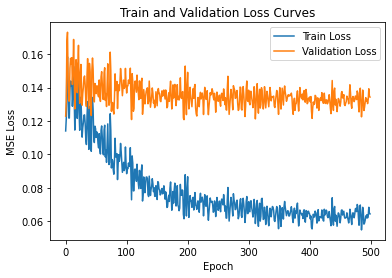

In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, data):
        self.X = torch.tensor([t[0] for t in data], dtype=torch.float32)
        self.Y = torch.tensor([t[1] for t in data], dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

np.random.seed(42)

def generate_data(num_samples):
    features = np.random.rand(num_samples, 26)
    labels = np.random.rand(num_samples, 1)
    return [(features[i], labels[i]) for i in range(num_samples)]

d1 = generate_data(100)
d2 = generate_data(100)
d3 = generate_data(100)

combined_data = d1 + d2 + d3
dataset = CustomDataset(combined_data)

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(26, 128),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Dropout(0.4),
        )

    def forward(self, x):
        return self.layers(x)

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
    return total_loss / total_samples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPRegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 500
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

    train_loss = evaluate(train_loader)
    val_loss = evaluate(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

test_loss = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}")

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Train and Validation Loss Curves")
plt.show()

